#### reference
https://www.kaggle.com/onlyshadow/a-practical-guide-to-ny-taxi-data-0-379 

# Summary 

- Problem : Predict taxi's trip duration (Kaggle Competitio : https://www.kaggle.com/c/nyc-taxi-trip-duration)
- Solution : XGboost regression model
- Data : Newyork taxi trip duration data
- Test result : 0.49 Root mean squared error for log y

### Data Explanation

id - a unique identifier for each trip   
vendor_id - a code indicating the provider associated with the trip record   
pickup_datetime - date and time when the meter was engaged   
dropoff_datetime - date and time when the meter was disengaged   
passenger_count - the number of passengers in the vehicle (driver entered value)   
pickup_longitude - the longitude where the meter was engaged   
pickup_latitude - the latitude where the meter was engaged   
dropoff_longitude - the longitude where the meter was disengaged   
dropoff_latitude - the latitude where the meter was disengaged   
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip   
trip_duration - duration of the trip in seconds   

In [2]:
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [157]:
path=os.getenv('HOME')+'/aiffel/kaggle/taxi_trip_duration/'

raw_train=pd.read_csv(path+'train.csv')
raw_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [161]:
raw_test=pd.read_csv(path+'test.csv')

x_train=raw_train.loc[:,:'trip_duration']
data=pd.concat([x_train, raw_test])

# 1. Preprocessing

## 1) 결측값 제거하기(Check missing value)

In [164]:
#check missing value
raw_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [165]:
raw_test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [174]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
data.pickup_datetime=pd.to_datetime(data.pickup_datetime)
data.dropoff_datetime=pd.to_datetime(data.dropoff_datetime)

## 2) 데이터 중복(Duplicated data)

In [175]:
#Check for duplicated data
raw_train.loc['passenger_count':].duplicated().sum()

0

In [176]:
raw_test.loc['passenger_count': ].duplicated().sum()

0

## 3) 정규화(Normalization)

<AxesSubplot:>

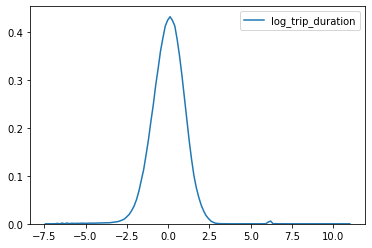

In [177]:
#The machine learning model learns better when the variable has approxiamtely normal distribution
#For such a reason, log transform and normalize the data so that the data exhibits bell shape
data['log_trip_duration']=np.log(data['trip_duration']+1)
data['log_trip_duration']=(data['log_trip_duration']-np.mean(data['log_trip_duration']))/np.std(data['log_trip_duration'])
sns.kdeplot(data['log_trip_duration'])

# 2. Feature Engineering

## 1) Create extra features (피처 추가하기)

### 1) Distance Traveled :  이동거리

In [178]:
#L1 : Abosolute difference between pickup & Dropoff location longitude and lattitude
#L2 : Distance between the pick up and drop off points
data['distance_travel_l1']=abs(data.pickup_longitude-data.dropoff_longitude)+abs(data.pickup_latitude-data.dropoff_latitude)
data['distance_travel_l2']=np.sqrt((data.pickup_longitude-data.dropoff_longitude)**2+(data.pickup_latitude-data.dropoff_latitude)**2)

In [179]:
data.distance_travel_l2

0         0.017680
1         0.020456
2         0.059934
3         0.013438
4         0.010690
            ...   
625129    0.008819
625130    0.065581
625131    0.096318
625132    0.199944
625133    0.053970
Name: distance_travel_l2, Length: 2083778, dtype: float64

### 2) Date & Weekends 

In [181]:
# Year, Month, Date, Weekday
data['year']=data.pickup_datetime.dt.year
data['month']=data.pickup_datetime.dt.month
data['date']=data.pickup_datetime.dt.day

In [182]:
data['weekday']=data.pickup_datetime.dt.weekday
data.weekday

0         0
1         6
2         1
3         2
4         5
         ..
625129    4
625130    4
625131    4
625132    4
625133    4
Name: weekday, Length: 2083778, dtype: int64

In [183]:
#if the weekday is 5 or 6 (Saturday, Sunday), holiday =1. Else 0
data['holiday']=0
data.loc[data['weekday']==5, 'holiday']=1
data.loc[data['weekday']==6, 'holiday']=1

### 3) Time of a day

In [184]:
data['hour']=data.pickup_datetime.dt.hour
data['minute']=data.pickup_datetime.dt.minute

In [185]:
#pickup time
data['time']=data.hour+data.minute/60

### 4) Pickup Location

In [186]:
import sklearn.cluster
from sklearn.cluster import KMeans

In [187]:
pickup_loc=data[['pickup_longitude', 'pickup_latitude']].values
dropoff_loc=data[['dropoff_longitude', 'dropoff_latitude']].values
move=np.hstack((pickup_loc, dropoff_loc))
kmeans=KMeans(n_clusters=10)
kmeans.fit(move)

KMeans(n_clusters=10)

In [188]:
pickup_loc.shape
data.shape

(2083778, 22)

In [189]:
len(pd.Series(kmeans.labels_))

2083778

In [190]:
#Categorize the taxis travel trajectories according to the pick up and drop off location using Kmeans algorithm
data['kmeans']=pd.Series(kmeans.labels_)

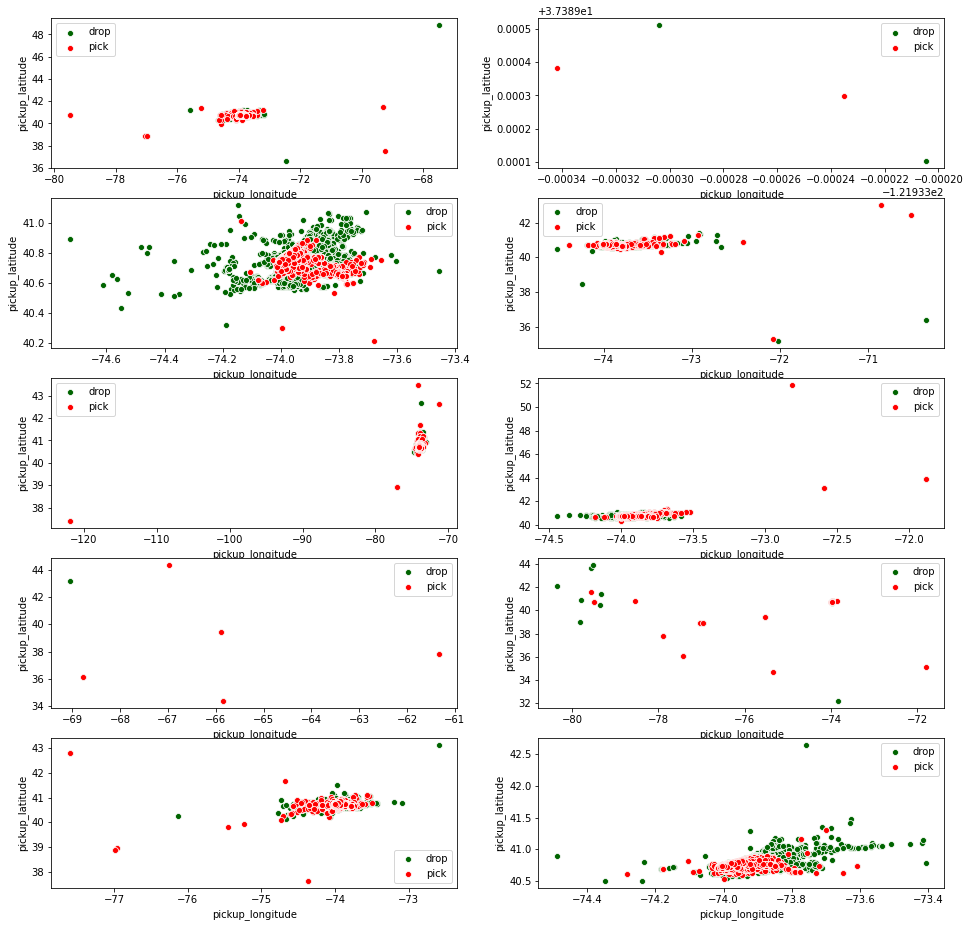

In [191]:
fig=plt.figure(figsize=(16,16))
for i in range(10):
    plt.subplot(5,2,i+1)
    sns.scatterplot('dropoff_longitude', 'dropoff_latitude',data=data[data['kmeans']==i], marker='o', color='darkgreen', label='drop')
    sns.scatterplot('pickup_longitude', 'pickup_latitude',data=data[data['kmeans']==i], marker='o', color='red', label='pick')
    plt.legend()

# 3. 이상치 및 분포 확인 (Discovering Outliers & Data distributions)
- 최대한 모든 데이터에 대해서 예측 할 수 있도록 만들어 모델의 예측력을 높이기 위해서 모델 학습 시 특정값을 이상치로 간주하고 제거하지는 않았음 (To improve the predicting capability of the model - can predict a likely output for any input data-, no outliers have been removed purposedly)
- 다만 EDA 시에 잘못 작성된 데이터가 있는지 확인하고 데이터간의 상관관계에 대한 이해를 높이기 위해 특이값에 대해 확인 및 제거를 임시로 진행(Outliers have been explored to check erroneously collected data and to foster understanding about the overall relationships between variables) 

## 1) 속도 이상치제거 및 거리와 소요 시간 사이의 관계 확인 (Outliers in Velocity removal and checking the correlation between distance traveled and duration)

이상치로 감지될 수 있는 지표들은 거리와 소요 시간 (속도가 너무 느리거나 빠른 경우) 로 볼 수 있다. 해당 지표를 살펴보자   
(Outliers may have too low or too high velocity.
Following is the relevant visualization)

<AxesSubplot:xlabel='distance_travel_l2', ylabel='trip_duration'>

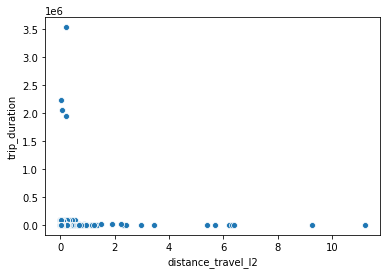

In [197]:
#Raw data : Some of the points seems like spending too much time for short travel 
# It is Outliers (Maybe an accident occured)
sns.scatterplot(x='distance_travel_l2', y='trip_duration', data=data)

<AxesSubplot:xlabel='distance_travel_l1', ylabel='trip_duration'>

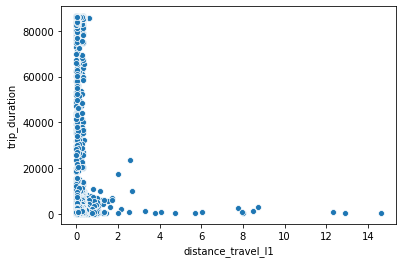

In [401]:
#Without outliers
#이상치를 제거한 뒤에도, 여전히 거리와 소요시간 간의 큰 상관관계를 알 수 없다.   
#Even when the outliers were deleted, no cleaer correlation between duration time and travel length is visible
sns.scatterplot(x='distance_travel_l1', y='trip_duration', data=data)

## 2) 시간 대 별 속도 확인

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

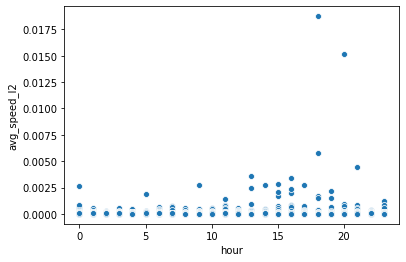

In [202]:
#Average speed in 24 hours of a day(During the working days). 
#Unusually high speed travelers are usually night drivers(18 - 21 pm)
#This holds true for the holiday too.
#18시 - 21시 사이에 특히 속도가 빠른 특이 값들이 도출되는것으로 보인다.   
weekday_train=data[data['holiday']==0]
sns.scatterplot(x='hour', y='avg_speed_l2',data=weekday_train)

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

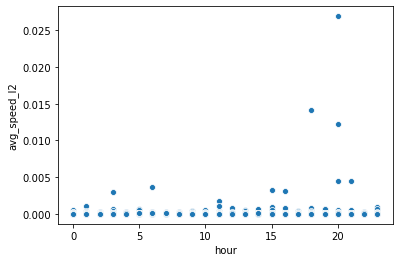

In [203]:
holiday_train=data[data['holiday']==1]
sns.scatterplot(x='hour', y='avg_speed_l2',data=holiday_train)

# 4. 추가적인 EDA (Extra EDA)

<AxesSubplot:>

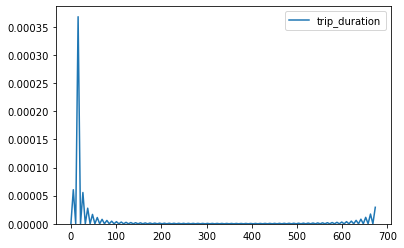

In [209]:
fig=plt.figure()
train.trip_duration=(train.trip_duration-np.mean(train.trip_duration))/(np.std(train.trip_duration))
sns.kdeplot(train['trip_duration'])
#Distribution of taxi trip duration
#Skewed distributions with outliers

<AxesSubplot:>

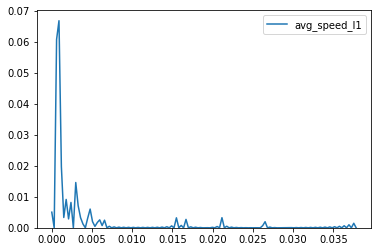

In [210]:
#Distribution of taxi trip speed
data['avg_speed_l1']=data['distance_travel_l1']/data['trip_duration']
sns.kdeplot(data['avg_speed_l1'])

## 1) 속도의 차이는 어디에서 올까? - 교통체증 확인하기 (What causes the taxi to slow down? - The traffic jam)

### (1) 어느 지역에 교통체증이 발생할까? (Where does traffic jam take place?)

하단 그래프를 보면 latitude 41부근, longitude -75 부근에 pickup 과 dropoff 가 특히 많은것으로 보인다.   
이는 해당 지역이 유동인구가 많은 지역이라 스팟으로의 이동이 몰려있는것이라고 합리적으로 추론할 수 있다.
The following graph shows lots of taxis pick up and drop off passengers near area near lat41, long-75
This lead us to conclusion that the spot may have heavy traffic with huge amount of floating population

<AxesSubplot:xlabel='dropoff_latitude', ylabel='avg_speed_l2'>

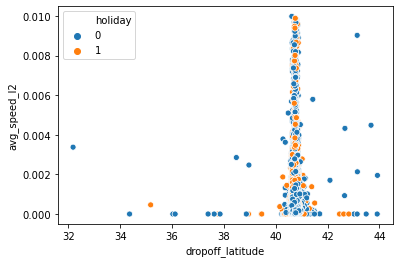

In [418]:
sns.scatterplot(x='dropoff_latitude', y='avg_speed_l2',hue='holiday', x_bins=40, data=data)

<AxesSubplot:xlabel='dropoff_longitude', ylabel='avg_speed_l2'>

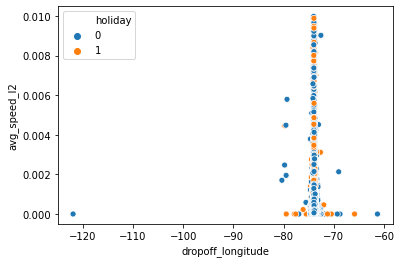

In [421]:
sns.scatterplot(x='dropoff_longitude', y='avg_speed_l2',hue='holiday', data=data)

### (2) 어느 시간대에 발생할까? (During what time of a day, is the traffic jam most serious?)

In [429]:
dawn=(data['hour']>=0)&(data['hour']<5)
morning=(data['hour']>=5)&(data['hour']<10)
noon=(data['hour']>=10)&(data['hour']<15)
evening=(data['hour']>=15)&(data['hour']<20)
night=(data['hour']>=20)

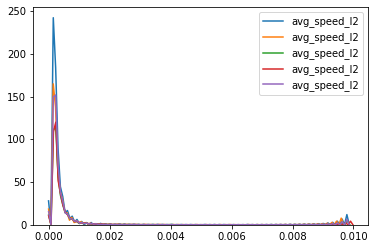

In [430]:
#The graph shows the distribution of each trip's average time
#The blue color = dawn -> Purple is night
# The dawn is fastest, and the noon is slowest
fig=plt.figure()
for i in [dawn, morning, noon, evening, night]:
    sns.kdeplot(data.loc[i, 'avg_speed_l2'])

In [431]:
#Showing average speed for each time block : Dawn to night time
# We get to the same result : Dawn is the fastes, noon is slowest
for i in [dawn, morning, noon, evening, night]:
    print(np.mean(data.loc[i, 'avg_speed_l2']))

6.529607310435346e-05
5.4283242536961816e-05
4.720868463075994e-05
4.838500733480354e-05
5.670593620412711e-05


<AxesSubplot:>

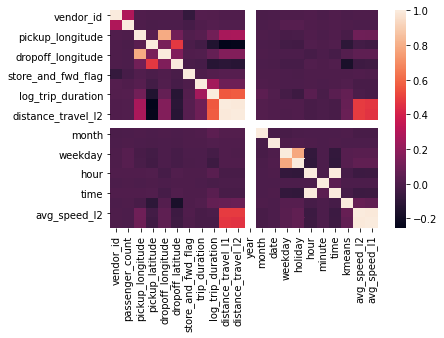

In [211]:
#checking heatmap : with log trip duration : the distance travel is most relevant
sns.heatmap(data.corr())

# 5. 데이터 형 변환 (Data types manipulations)

In [206]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
log_trip_duration            float64
distance_travel_l1           float64
distance_travel_l2           float64
year                           int64
month                          int64
date                           int64
weekday                        int64
holiday                        int64
hour                           int64
minute                         int64
time                         float64
kmeans                         int32
avg_speed_l2                 float64
dtype: object

"Object" 타입을 변형해줘야함 (Object type should be changed to other types)

In [207]:
data['store_and_fwd_flag']
data.replace(to_replace='N', value=0, inplace=True)
data.replace(to_replace='Y', value=1, inplace=True)

In [208]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,date,weekday,holiday,hour,minute,time,kmeans,avg_speed_l2
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,2016,3,14,0,0,17,24,17.400000,4,0.000039
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,2016,6,12,6,1,0,43,0.716667,8,0.000031
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,2016,1,19,1,0,11,35,11.583333,8,0.000028
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,2016,4,6,2,0,19,32,19.533333,8,0.000031
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,2016,3,26,5,1,13,30,13.500000,4,0.000025


# 6. Model

## 1) data 정리하기 (X, Y, Train, Test, Validation Data Preparation)

In [212]:
data.head()
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'distance_travel_l1',
       'distance_travel_l2', 'year', 'month', 'date', 'weekday', 'holiday',
       'hour', 'minute', 'time', 'kmeans', 'avg_speed_l2', 'avg_speed_l1'],
      dtype='object')

In [213]:
feature=['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'distance_travel_l1', 'distance_travel_l2', 'year',
       'month', 'date', 'weekday', 'holiday','time',
       'kmeans']

In [214]:
train=data.iloc[:1458643,:]
test=data.iloc[1458644:,:]

In [217]:
print(test.shape, raw_test.shape)

(625134, 25) (625134, 9)


In [218]:
train.isna().sum()
train.dropna(how='any', inplace=True)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [219]:
test.isna().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime      625134
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration         625134
log_trip_duration     625134
distance_travel_l1         0
distance_travel_l2         0
year                       0
month                      0
date                       0
weekday                    0
holiday                    0
hour                       0
minute                     0
time                       0
kmeans                     0
avg_speed_l2          625134
avg_speed_l1          625134
dtype: int64

In [220]:
x_train=train[feature]
y_train=train['log_trip_duration'].values
x_test=test[feature]
x_test.isna().sum()

vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
distance_travel_l1    0
distance_travel_l2    0
year                  0
month                 0
date                  0
weekday               0
holiday               0
time                  0
kmeans                0
dtype: int64

In [221]:
print(train.shape, test.shape, x_train.shape, y_train.shape)

(1458643, 25) (625134, 25) (1458643, 15) (1458643,)


In [222]:
x_pre_train, x_val, y_pre_train, y_val=sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.2)

In [223]:
x_pre_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_travel_l1,distance_travel_l2,year,month,date,weekday,holiday,time,kmeans
1089277,2,1,-73.995354,40.688110,-73.959602,40.675716,0.048145,0.037839,2016,5,6,4,0,23.866667,8
1095570,2,6,-73.970589,40.757992,-73.984032,40.765125,0.020576,0.015218,2016,6,25,5,1,17.766667,0
102067,2,1,-74.006943,40.752941,-73.931587,40.796089,0.118504,0.086834,2016,5,4,2,0,20.983333,4
1038376,1,1,-73.901268,40.745754,-73.912720,40.755798,0.021496,0.015232,2016,5,17,1,0,2.316667,5
608093,2,1,-73.978813,40.762520,-73.955902,40.767982,0.028374,0.023553,2016,4,5,1,0,21.850000,4


## 2)  Model set up / Compile / Learning

-  Utilized XGBoost model which is fast and shows great performance
- Evaluation metrics : RMSE 

In [226]:
import xgboost as xgb

data_tr  = xgb.DMatrix(x_pre_train, label=y_pre_train)
data_cv  = xgb.DMatrix(x_val, label=y_val)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [227]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[20:25:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.88280	valid-rmse:0.88113
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.46785	valid-rmse:0.49886
[200]	train-rmse:0.44806	valid-rmse:0.49822
Stopping. Best iteration:
[175]	train-rmse:0.45182	valid-rmse:0.49786

[20:26:40] WARNING: /home/conda/feedstock_root/build_ar

In [228]:
#Root mean squared error for Taxi trip : 0.497
print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

score = 0.49786, n_boost_round =175.
